# Lesson 29: PyTorch training loop activity

In this activity, you will modify the basic PyTorch training loop from the lesson 29 demo to add:

1. **Batching** - Process the training data in mini-batches instead of all at once
2. **Validation** - Track model performance on a held-out validation set during training

## Notebook set-up

### Imports

In [2]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(320)
np.random.seed(320)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. Load preprocessed data

In [3]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')

training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

print(f'Training samples: {len(training_df)}')
print(f'Testing samples: {len(testing_df)}')
print(f'Features: {features}')
print(f'Label: {label}')

Training samples: 15480
Testing samples: 5160
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: MedHouseVal


## 2. Prepare PyTorch tensors and DataLoaders

### Task 1: Add batching and validation split

Currently, the code below creates tensors for training and testing. Your task is to:

1. **Add imports** for `TensorDataset` and `DataLoader` from `torch.utils.data`
2. **Split training data** into train and validation sets (e.g., 80/20 split)
3. **Create DataLoaders** for batched training

**Hints:**
- Use `torch.randperm()` to shuffle indices for the split
- Use `TensorDataset(X, y)` to combine feature and label tensors
- Use `DataLoader(dataset, batch_size=32, shuffle=True)` to create batches
- Create separate DataLoaders for training and validation

In [ ]:
# Convert dataframes to PyTorch tensors and move to device
X_train = torch.tensor(training_df[features].values, dtype=torch.float32).to(device)
y_train = torch.tensor(training_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

X_test = torch.tensor(testing_df[features].values, dtype=torch.float32).to(device)
y_test = torch.tensor(testing_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [20]:
n_samples = X_train.shape[0]
n_val = int(n_samples * 0.2)
n_train = n_samples - n_val

indices = torch.randperm(X_train.shape[0])
train_indices = indices[:n_train]
val_indices = indices[n_train:]

print(f'Training set size: {n_train}')
print(f'Validation set size: {n_val}')

Training set size: 12384
Validation set size: 3096


In [17]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape) 
    break 

torch.Size([32, 8]) torch.Size([32, 1])


## 3. Build model

In [6]:
model = nn.Sequential(
    nn.Linear(8, 64), # Fully connected layer (similar to tf.keras.layers.Dense)
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1)
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
)


## 4. Training function

### Task 2: Update training loop for batching and validation

The current training loop processes all training data at once. Your task is to modify this function to:

1. **Accept DataLoaders** instead of raw tensors
2. **Iterate over batches** in an inner loop within each epoch
3. **Compute validation metrics** after each training epoch

**Hints:**
- Change function signature to accept `train_loader` and `val_loader` instead of `X_train`, `y_train`
- Add an inner `for X_batch, y_batch in train_loader:` loop
- Accumulate loss across batches, then average for reporting
- Use `model.eval()` and `torch.no_grad()` for validation
- Track `val_loss` and `val_r2` in the history dictionary

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: torch.Tensor,
    # val_loader: torch.Tensor,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 50,
    print_every: int = 5
) -> dict[str, list[float]]:
    '''Basic training loop for PyTorch model.
    
    TODO: Modify this function to add:
    1. Batching - process data in mini-batches
    2. Validation - track performance on a validation set
    '''

    
        
    
    history = {'avg_loss': [], 'avg_r2': [], 'val': []}
    batch_history = {'loss': [], 'r2': [], 'val': []}
    
    for epoch in range(epochs):

        epoch_train_loss=0.0
        epoch_val_loss =0.0
        n_batches = 0
        # Set model to training mode
        model.train()
        
        #Put loop here to watch and send data in batches per epoch, we do not need to retrain every time
        for (X_train, y_train), (X_val, y_val) in zip(train_loader,val_loader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(X_train)
            
            # Calculate loss
            loss = criterion(predictions, y_train)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()

            val_predictions = model(X_val)
            val_loss = criterion(val_predictions, y_val)
            epoch_val_loss += val_loss.item()
            
            # Calculate R²
            with torch.no_grad():
                ss_res = torch.sum((y_train - predictions) ** 2)
                ss_tot = torch.sum((y_train - torch.mean(y_train)) ** 2)
                r2 = 1 - (ss_res / ss_tot)

            batch_history['loss'].append(loss.item())
            batch_history['r2'].append(r2.item())
            batch_history['val'].append(val_loss.item())
        
        # Record metrics
        val_loss = np.mean(batch_history['loss'])
        val_r2 = np.mean(batch_history['r2'])
        history['avg_loss'].append(val_loss.item())
        history['avg_r2'].append(val_r2.item())
        history['avg_val'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs} - loss: {loss.item():.4f} - R²: {r2.item():.4f} - val_loss: {val}')
    
    print('\nTraining complete.')
    return history

## 5. Train model

In [28]:
history = train_model(
    model=model,
    train_loader=train_loader,
    # y_train=y_train,
    criterion=criterion,
    optimizer=optimizer,
    epochs=100,
    print_every=10
)

Epoch 1/100 - loss: 0.2394 - R²: 0.6905 - val_loss: {'loss': [np.float64(0.26028401905923715)]}
Epoch 10/100 - loss: 0.3410 - R²: 0.5870 - val_loss: {'loss': [np.float64(0.26028401905923715), np.float64(0.26215514115253347), np.float64(0.26760714166939503), np.float64(0.26367656310537346), np.float64(0.2625817811323537), np.float64(0.2624351999189689), np.float64(0.26254452859269983), np.float64(0.26247754715739485), np.float64(0.2623978861069769), np.float64(0.2623785394646319)]}
Epoch 20/100 - loss: 0.3633 - R²: 0.6996 - val_loss: {'loss': [np.float64(0.26028401905923715), np.float64(0.26215514115253347), np.float64(0.26760714166939503), np.float64(0.26367656310537346), np.float64(0.2625817811323537), np.float64(0.2624351999189689), np.float64(0.26254452859269983), np.float64(0.26247754715739485), np.float64(0.2623978861069769), np.float64(0.2623785394646319), np.float64(0.26304084259711463), np.float64(0.2620423354319615), np.float64(0.2625392452572231), np.float64(0.261854883373716

## 6. Learning curves

**Note:** Once you add validation, update these plots to show both training and validation metrics.

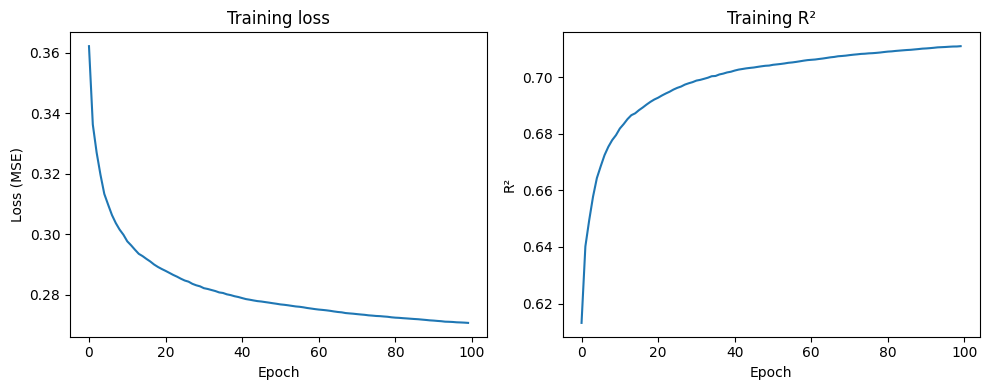

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Training loss')
axes[0].plot(history['avg_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')

axes[1].set_title('Training R²')
axes[1].plot(history['avg_r2'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R²')

plt.tight_layout()
plt.show()

## 7. Test set evaluation

In [13]:
# Set model to evaluation mode
model.eval()

# Make predictions (no gradient calculation needed)
with torch.no_grad():
    predictions = model(X_test).cpu().numpy().flatten()

# Calculate R²
ss_res = np.sum((testing_df[label].values - predictions) ** 2)
ss_tot = np.sum((testing_df[label].values - np.mean(testing_df[label].values)) ** 2)
rsquared = 1 - (ss_res / ss_tot)

print(f'Model R² on test set: {rsquared:.4f}')

Model R² on test set: 0.7569


## 8. Performance analysis

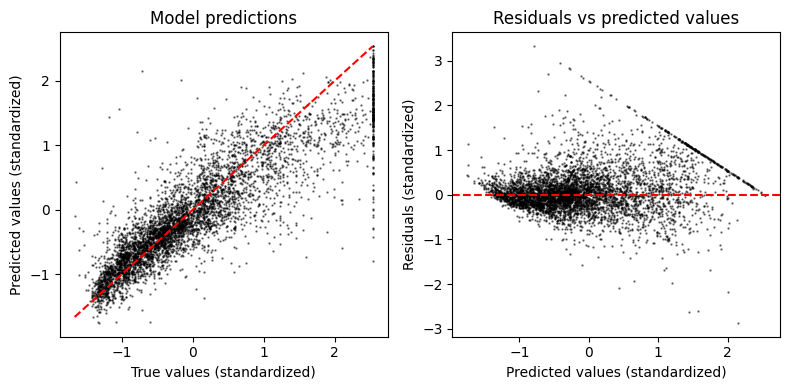

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Model predictions')
axes[0].scatter(
    testing_df[label], predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    predictions, testing_df[label] - predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()